In [ ]:
import sys, os
import pickle
sys.path.append('..')
sys.path.append('../..')

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
from scipy.stats import t 
from itertools import product
import pystan

from viabel.vb import (mean_field_gaussian_variational_family,
                       mean_field_t_variational_family,
                       full_rank_gaussian_variational_family,
                       t_variational_family,
                       make_stan_log_density, 
                       adagrad_optimize)
from experiments import *

sns.set_style('white')
sns.set_context('notebook', font_scale=2.5, rc={'lines.linewidth': 2})

In [ ]:
from viabel.vb import  rmsprop_IA_optimize_with_rhat, adam_IA_optimize_with_rhat

In [ ]:
def plot_sample_contours(x_samples1, y_samples1, x_samples2, y_samples2, xlabel, ylabel, xlim, ylim, 
                    cmap1, cmap2, savepath=None, **kwargs):
    sns.kdeplot(x_samples1, y_samples1, cmap=cmap1, **kwargs)
    sns.kdeplot(x_samples2, y_samples2, cmap=cmap2, **kwargs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks([])
    plt.yticks([])
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    
def plot_sample_and_density_contours(x_samples, y_samples, logdensity, xlabel, ylabel, xlim, ylim, 
                    cmap_samples, cmap_density, savepath=None, **kwargs):
    sns.kdeplot(x_samples, y_samples, cmap=cmap_samples, **kwargs)
    x = np.linspace(*xlim, 100)
    y = np.linspace(*ylim, 100)
    X, Y = np.meshgrid(x, y)
    XY = np.concatenate([X[:,:,np.newaxis], Y[:,:,np.newaxis]], axis=2)
    Z = np.exp(logdensity(XY))
    plt.contour(X, Y, Z, cmap=cmap_density, linestyles='solid')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks([])
    plt.yticks([])
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    
def tranform_to_theta(ncp_samples):
    ncp_samples_tranformed = ncp_samples.copy()
    ncp_samples_tranformed[2:] = (ncp_samples_tranformed[0] 
                                  + np.exp(ncp_samples_tranformed[1]) * ncp_samples_tranformed[2:])
    return ncp_samples_tranformed

def get_ncp_approx_samples(var_family, opt_param, n_samples):
    ncp_samples = var_family.sample(opt_param, n_samples).T
    return ncp_samples, tranform_to_theta(ncp_samples)

In [ ]:
try:
    cp = pickle.load(open('eight_schools_cp.pkl', 'rb'))
except:
    cp = pystan.StanModel(file='eight_schools_cp.stan', model_name='eight_School_cp_model')
    with open('eight_schools_cp.pkl', 'wb') as f:
        pickle.dump(cp, f)

In [6]:
try:
    ncp = pickle.load(open('eight_schools_ncp.pkl', 'rb'))
except:
    ncp = pystan.StanModel(file='eight_schools_ncp.stan', model_name='eight_School_ncp_model')
    with open('eight_schools_ncp.pkl', 'wb') as f:
        pickle.dump(ncp, f)

In [7]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
data = dict(J=J, y=y, sigma=sigma)

In [8]:
eight_schools_cp_fit = cp.sampling(data=data, iter=11000, warmup=1000,
                                                            control=dict(adapt_delta=.99))

In [9]:
eight_schools_ncp_fit = ncp.sampling(data=data, iter=32000, warmup=2000, thin=3,
                                                              control=dict(adapt_delta=.95))

In [10]:
eight_schools_ncp_fit

Inference for Stan model: eight_School_model_83f1609305e7267422b692fbee65a5db.
4 chains, each with iter=32000; warmup=2000; thin=3; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               4.39    0.02   3.33  -2.18   2.15    4.4   6.62  10.86  40809    1.0
tau               3.6    0.02   3.23   0.12   1.25   2.74   4.99  11.97  38883    1.0
theta_tilde[1]   0.32  5.1e-3   0.99  -1.66  -0.34   0.33   0.99   2.23  38065    1.0
theta_tilde[2]    0.1  4.7e-3   0.94  -1.78  -0.53   0.11   0.73   1.92  40369    1.0
theta_tilde[3]  -0.09  4.8e-3   0.97  -1.97  -0.74   -0.1   0.56   1.83  40079    1.0
theta_tilde[4]   0.06  4.7e-3   0.95  -1.82  -0.57   0.07    0.7   1.91  40531    1.0
theta_tilde[5]  -0.16  4.6e-3   0.93  -1.97  -0.79  -0.17   0.45   1.68  40885    1.0
theta_tilde[6]  -0.08  4.7e-3   0.94  -1.95  -0.71  -0.09   0.54   1.79  40130    1.0
theta_tilde[7]   0.35  4.8

In [11]:
# number of parameters and parameter names in centered model
n_params_cp = len(eight_schools_cp_fit.constrained_param_names())
param_names_cp = ['mu', 'log_tau'] + eight_schools_cp_fit.flatnames[2:n_params_cp]

# number of parameters and parameter names in non-centered model
n_params_ncp = len(eight_schools_ncp_fit.constrained_param_names())
param_names_ncp = ['mu', 'log_tau'] + eight_schools_ncp_fit.flatnames[2:n_params_ncp]
param_names_ncp_transformed = ['mu', 'log_tau'] + eight_schools_ncp_fit.flatnames[n_params_ncp:]


# construct matrix of samples (both original and transformed) from non-centered model 
samples_ncp_df = eight_schools_ncp_fit.to_dataframe(pars=eight_schools_ncp_fit.flatnames)
samples_ncp_df['log_tau'] = np.log(samples_ncp_df['tau'])
samples_ncp = samples_ncp_df.loc[:,param_names_ncp].values.T
samples_ncp_transformed = samples_ncp_df.loc[:,param_names_ncp_transformed].values.T

# use samples from non-centered model for ground true mean and covariance
true_mean_ncp = np.mean(samples_ncp, axis=1)
true_cov_ncp = np.cov(samples_ncp)
true_sigma_ncp = np.sqrt(np.diag(true_cov_ncp))
true_mean_ncp_tranformed = np.mean(samples_ncp_transformed, axis=1)
true_cov_ncp_tranformed = np.cov(samples_ncp_transformed)

In [12]:
k=10
print(true_mean_ncp)
print(len(true_mean_ncp))

[ 4.38767556  0.79967389  0.32151237  0.0982932  -0.08746935  0.06140726
 -0.16142935 -0.08317314  0.35488422  0.07969202]
10


In [13]:
eight_schools_cp_log_density = make_stan_log_density(eight_schools_cp_fit)
eight_schools_ncp_log_density = make_stan_log_density(eight_schools_ncp_fit)
mf_gaussian_cp = mean_field_gaussian_variational_family(n_params_cp)
mf_gaussian_ncp = mean_field_gaussian_variational_family(n_params_ncp)

#### Lets run ADVI with very good initialisation on centred parameterisation

In [14]:
good_init_param_cp1 = np.concatenate([true_mean_ncp_tranformed, .5*np.log(np.diag(true_cov_ncp_tranformed))])
bad_init_param_cp1 = np.concatenate([np.zeros(k), np.ones(k)])

klvi_mf_objective_and_grad_cp = black_box_klvi(mf_gaussian_cp, eight_schools_cp_log_density, 100)
klvi_mf_objective_and_grad_ncp = black_box_klvi(mf_gaussian_cp, eight_schools_ncp_log_density, 100)

In [15]:
klvi_var_param_rms_good_cp, klvi_var_param_list_rms_good_cp, avg_klvi_mean_list_rms_good_cp, avg_klvi_sigmas_list_rms_good_cp, klvi_history_rms_good_cp, _, op_log_mf_rms_good_cp = \
    rmsprop_IA_optimize_with_rhat(9000, klvi_mf_objective_and_grad_cp, good_init_param_cp1, k, learning_rate=.01,n_optimisers=2, r_mean_threshold=1.20, tail_avg_iters=3000)

Average Loss = -7.65127: 100%|██████████| 9000/9000 [01:15<00:00, 118.83it/s]


##### Iterations taken for convergence of mean and sigma params

Interesting to see, although the objective value had already stabilised around iteration number 4000, but the Rhat signalled convergence much later, indicating that while the objective value looks stable on the surface, the parameters are still changing under the hood.

In [17]:
print(op_log_mf_rms_good_cp['start_avg_mean_iters'])
print(op_log_mf_rms_good_cp['start_avg_sigma_iters'])

1500
1000


In [18]:
R_hat_mean_window_rms_cp = op_log_mf_rms_good_cp['r_hat_mean']
R_hat_sigma_window_rms_cp = op_log_mf_rms_good_cp['r_hat_sigma']
R_hat_mean_halfway_rms_cp = op_log_mf_rms_good_cp['r_hat_mean_halfway']
R_hat_sigma_halfway_rms_cp = op_log_mf_rms_good_cp['r_hat_sigma_halfway']

(0.8, 2.5)

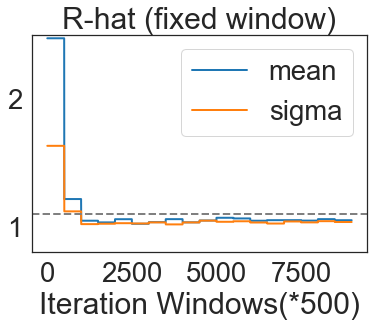

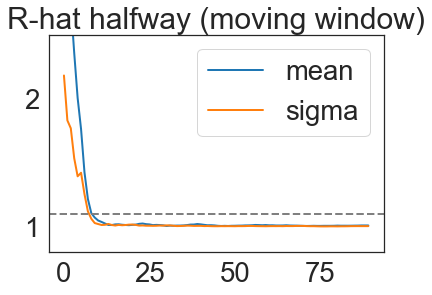

In [19]:
plt.plot(np.repeat(np.mean(R_hat_mean_window_rms_cp, axis=1), 500), label='mean')
plt.plot(np.repeat(np.mean(R_hat_sigma_window_rms_cp, axis=1), 500), label='sigma')
plt.ylim((0.8,2.5))
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.title('R-hat (fixed window)')
plt.legend()
plt.xlabel('Iteration Windows(*500)')

plt.figure()
plt.plot(np.mean(R_hat_mean_halfway_rms_cp, axis=1), label='mean')
plt.plot(np.mean(R_hat_sigma_halfway_rms_cp, axis=1), label='sigma')
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.title('R-hat halfway (moving window)')
plt.legend()
plt.ylim((0.8,2.5))

#### Plot for evolution of l2 norm over all mean parameters

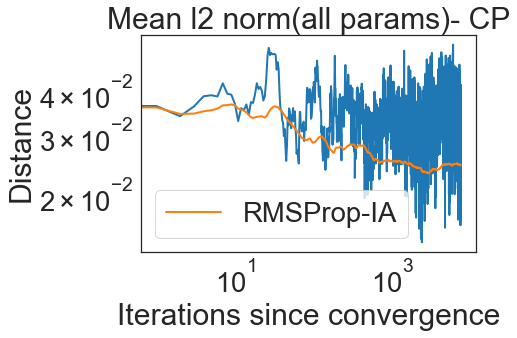

In [20]:
plt.loglog(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_good_cp[0][op_log_mf_rms_good_cp['start_avg_mean_iters']:,:k] - true_mean_ncp)), axis=1))
plt.plot(np.mean(np.sqrt(np.square(avg_klvi_mean_list_rms_good_cp[0] - true_mean_ncp)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('Distance')
plt.title('Mean l2 norm(all params)- CP')
plt.legend()

#### Plot for evolution of l2 norm over all sigma parameters

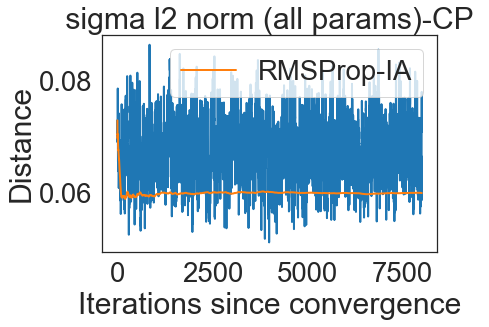

In [46]:
plt.plot(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_good_cp[0][op_log_mf_rms_good_cp['start_avg_sigma_iters']:,k:] - np.log(np.sqrt(np.diag(true_cov_ncp))))), axis=1))
plt.plot(np.mean(np.sqrt(np.square(avg_klvi_sigmas_list_rms_good_cp[0] - np.log(np.sqrt(np.diag(true_cov_ncp))))), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('Distance')
plt.title(' sigma l2 norm (all params)-CP ')
plt.legend()

In [22]:
#### Plot for evolution of l2 norm over all mean parameters

##### We observe high correlation among iterates for group mean parameter - something which is shown in the Rhat plot later... 

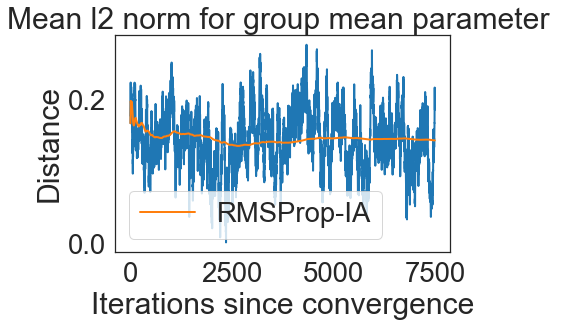

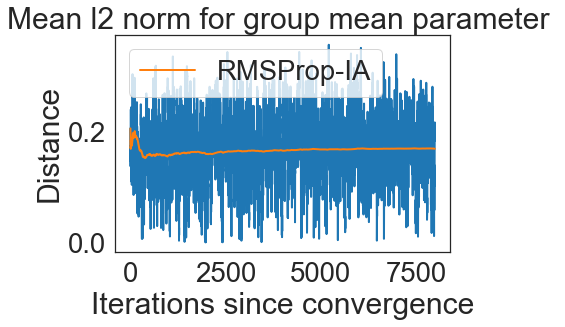

In [30]:
plt.plot(np.sqrt(np.square(klvi_var_param_list_rms_good_cp[0][op_log_mf_rms_good_cp['start_avg_mean_iters']:,0] - true_mean_ncp[0])))
plt.plot(np.sqrt(np.square(avg_klvi_mean_list_rms_good_cp[0][:,0] - true_mean_ncp[0])), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('Distance')
plt.title('Mean l2 norm for group mean parameter ')
plt.legend()

plt.figure()
plt.plot(np.sqrt(np.square(np.exp(klvi_var_param_list_rms_good_cp[0][op_log_mf_rms_good_cp['start_avg_sigma_iters']:,k]) - true_sigma_ncp[0])))
plt.plot(np.sqrt(np.square(np.exp(avg_klvi_sigmas_list_rms_good_cp[0][:,0]) - true_sigma_ncp[0])), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('Distance')
plt.title('Mean l2 norm for group mean parameter ')
plt.legend()



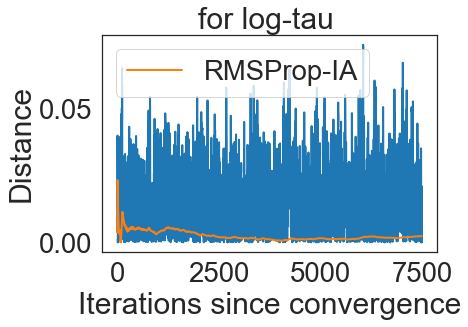

In [24]:
plt.plot(np.sqrt(np.square(klvi_var_param_list_rms_good_cp[0][op_log_mf_rms_good_cp['start_avg_mean_iters']:,1] - true_mean_ncp[1])))
plt.plot(np.sqrt(np.square(avg_klvi_mean_list_rms_good_cp[0][:,1] - true_mean_ncp[1])), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('Distance')
plt.title('for log-tau ')
plt.legend()

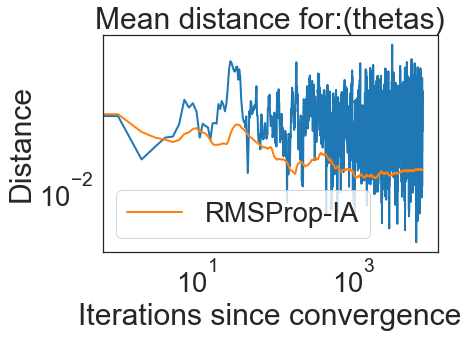

In [25]:
plt.loglog(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_good_cp[0][op_log_mf_rms_good_cp['start_avg_mean_iters']:,2:k] - true_mean_ncp[2:])), axis=1))
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_mean_list_rms_good_cp[0][:,2:k] - true_mean_ncp[2:])), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('Distance')
plt.title('Mean distance for:(thetas)')
plt.legend()

#### R hat plot fixed window and halfway  for iterates of mu and log(tau) - window size (500)

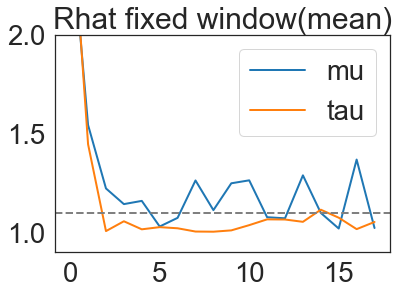

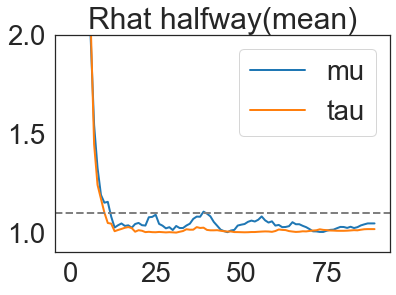

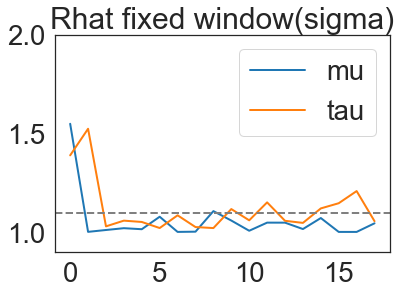

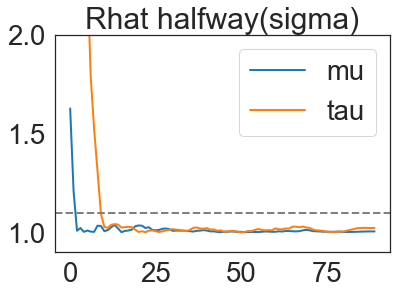

In [26]:
plt.plot(R_hat_mean_window_rms_cp[:,0], label='mu')
plt.plot(R_hat_mean_window_rms_cp[:,1], label='tau')
plt.ylim((0.9,2))
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.title('Rhat fixed window(mean)')
plt.legend()


plt.figure()
plt.plot(R_hat_mean_halfway_rms_cp[:,0], label='mu')
plt.plot(R_hat_mean_halfway_rms_cp[:,1], label='tau')
plt.ylim((0.9,2))
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.title('Rhat halfway(mean)')
plt.legend()

plt.figure()
plt.plot(R_hat_sigma_window_rms_cp[:,0], label='mu')
plt.plot(R_hat_sigma_window_rms_cp[:,1], label='tau')
plt.ylim((0.9,2))
plt.title('Rhat fixed window(sigma)')
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.legend()


plt.figure()
plt.plot(R_hat_sigma_halfway_rms_cp[:,0], label='mu')
plt.plot(R_hat_sigma_halfway_rms_cp[:,1], label='tau')
plt.ylim((0.9,2))
plt.title('Rhat halfway(sigma)')
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.legend()
#plt.plot(R_hat_mean[:,2:])

#### R hat plot for iterates for thetas using constant ffixed size window of 500

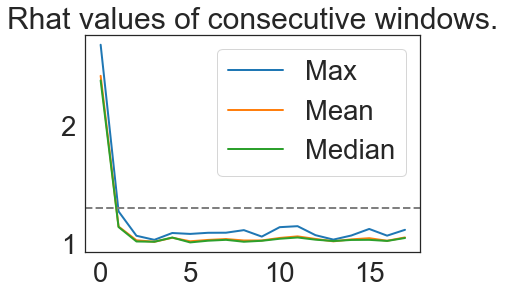

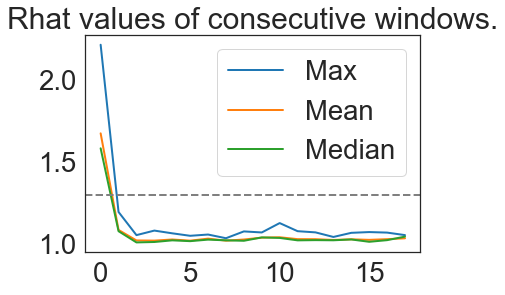

In [27]:
plt.plot(np.max(R_hat_mean_window_rms_cp[:,2:],axis=1), label='Max')
plt.plot(np.mean(R_hat_mean_window_rms_cp[:,2:],axis=1), label='Mean')
plt.plot(np.median(R_hat_mean_window_rms_cp[:,2:],axis=1), label='Median')
plt.axhline(y=1.30, linestyle='--', color="gray")
plt.title('Rhat values of consecutive windows.')
plt.legend()

plt.figure()
plt.plot(np.max(R_hat_sigma_window_rms_cp[:,2:],axis=1), label='Max')
plt.plot(np.mean(R_hat_sigma_window_rms_cp[:,2:],axis=1), label='Mean')
plt.plot(np.median(R_hat_sigma_window_rms_cp[:,2:],axis=1), label='Median')
plt.axhline(y=1.30, linestyle='--', color="gray")
plt.title('Rhat values of consecutive windows.')
plt.legend()

#### Now, Lets run ADVI with very good initialisation on non-centred parameterisation

In [29]:
klvi_var_param_rms_good_ncp, klvi_var_param_list_rms_good_ncp, avg_klvi_mean_list_rms_good_ncp, avg_klvi_sigmas_list_rms_good_ncp, klvi_history_rms_good_ncp, _, op_log_mf_rms_good_ncp = \
    rmsprop_IA_optimize_with_rhat(11000, klvi_mf_objective_and_grad_ncp, good_init_param_cp1, k, learning_rate=.01,n_optimisers=2, r_mean_threshold=1.15, tail_avg_iters=3000)

Average Loss = -7.65109: 100%|██████████| 11000/11000 [01:37<00:00, 112.48it/s]


In [31]:
R_hat_mean_window_rms_ncp = op_log_mf_rms_good_ncp['r_hat_mean']
R_hat_sigma_window_rms_ncp = op_log_mf_rms_good_ncp['r_hat_sigma']
R_hat_mean_halfway_rms_ncp = op_log_mf_rms_good_ncp['r_hat_mean_halfway']
R_hat_sigma_halfway_rms_ncp = op_log_mf_rms_good_ncp['r_hat_sigma_halfway']

In [32]:
####  Rhat  window  and Rhat halfway for noncentred parameterisation.

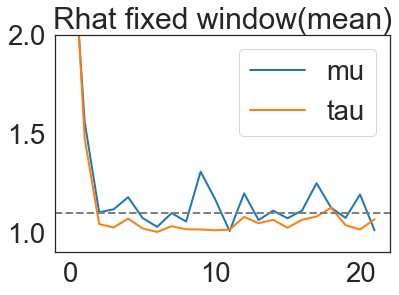

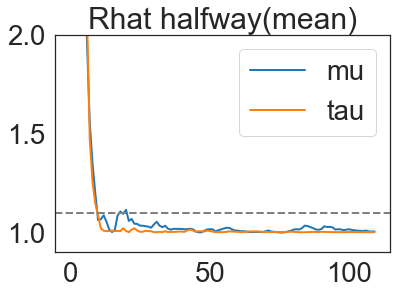

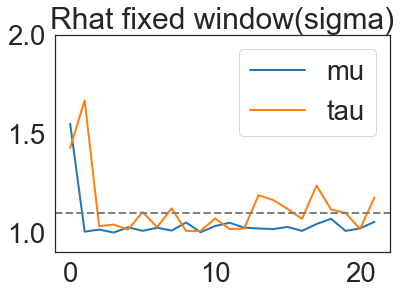

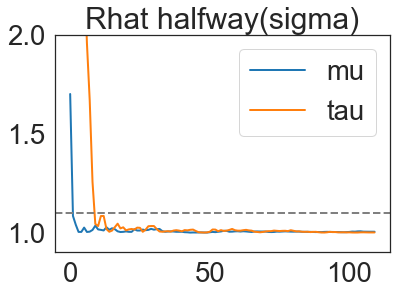

In [33]:
plt.plot(R_hat_mean_window_rms_ncp[:,0], label='mu')
plt.plot(R_hat_mean_window_rms_ncp[:,1], label='tau')
plt.ylim((0.9,2))
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.title('Rhat fixed window(mean)')
plt.legend()


plt.figure()
plt.plot(R_hat_mean_halfway_rms_ncp[:,0], label='mu')
plt.plot(R_hat_mean_halfway_rms_ncp[:,1], label='tau')
plt.ylim((0.9,2))
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.title('Rhat halfway(mean)')
plt.legend()

plt.figure()
plt.plot(R_hat_sigma_window_rms_ncp[:,0], label='mu')
plt.plot(R_hat_sigma_window_rms_ncp[:,1], label='tau')
plt.ylim((0.9,2))
plt.title('Rhat fixed window(sigma)')
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.legend()


plt.figure()
plt.plot(R_hat_sigma_halfway_rms_ncp[:,0], label='mu')
plt.plot(R_hat_sigma_halfway_rms_ncp[:,1], label='tau')
plt.ylim((0.9,2))
plt.title('Rhat halfway(sigma)')
plt.axhline(y=1.10, linestyle='--', color="gray")
plt.legend()
#plt.plot(R_hat_mean[:,2:])

#### Iterations taken to convergence according to Rhat Fixed window

In [34]:
print(op_log_mf_rms_good_ncp['start_avg_mean_iters'])
print(op_log_mf_rms_good_ncp['start_avg_sigma_iters'])

2500
1000


In [ ]:
###

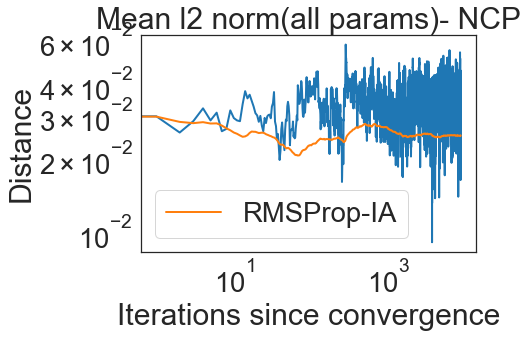

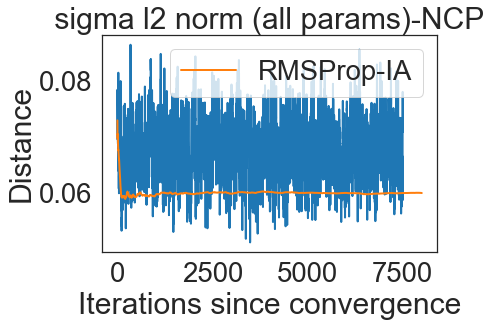

In [36]:
plt.loglog(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_good_ncp[0][op_log_mf_rms_good_ncp['start_avg_mean_iters']:,:k] - true_mean_ncp)), axis=1))
plt.plot(np.mean(np.sqrt(np.square(avg_klvi_mean_list_rms_good_ncp[0] - true_mean_ncp)), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('Distance')
plt.title('Mean l2 norm(all params)- NCP')
plt.legend()

plt.figure()
plt.plot(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_good_cp[0][op_log_mf_rms_good_cp['start_avg_mean_iters']:,k:] - np.log(np.sqrt(np.diag(true_cov_ncp))))), axis=1))
plt.plot(np.mean(np.sqrt(np.square(avg_klvi_sigmas_list_rms_good_cp[0] - np.log(np.sqrt(np.diag(true_cov_ncp))))), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('Distance')
plt.title(' sigma l2 norm (all params)-NCP ')
plt.legend()


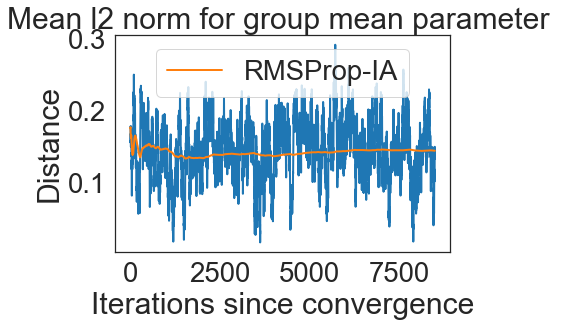

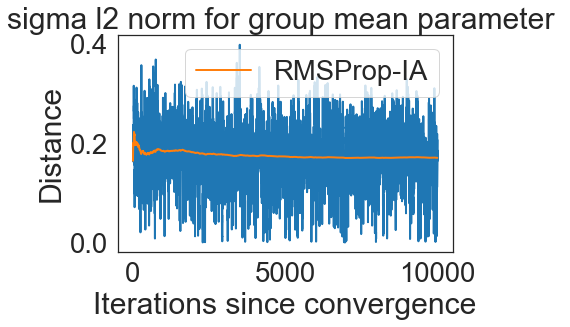

In [38]:
plt.plot(np.sqrt(np.square(klvi_var_param_list_rms_good_ncp[0][op_log_mf_rms_good_ncp['start_avg_mean_iters']:,0] - true_mean_ncp[0])))
plt.plot(np.sqrt(np.square(avg_klvi_mean_list_rms_good_ncp[0][:,0] - true_mean_ncp[0])), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('Distance')
plt.title('Mean l2 norm for group mean parameter ')
plt.legend()

plt.figure()
plt.plot(np.sqrt(np.square(np.exp(klvi_var_param_list_rms_good_ncp[0][op_log_mf_rms_good_ncp['start_avg_sigma_iters']:,k]) - true_sigma_ncp[0])))
plt.plot(np.sqrt(np.square(np.exp(avg_klvi_sigmas_list_rms_good_ncp[0][:,0]) - true_sigma_ncp[0])), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('Distance')
plt.title('sigma l2 norm for group mean parameter ')
plt.legend()

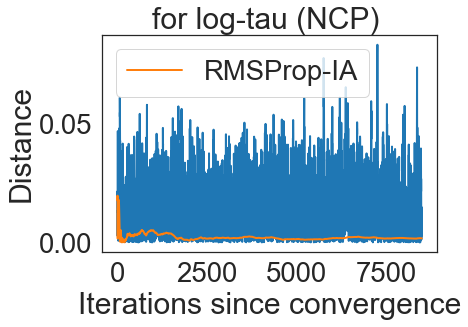

In [41]:

plt.plot(np.sqrt(np.square(klvi_var_param_list_rms_good_ncp[0][op_log_mf_rms_good_ncp['start_avg_mean_iters']:,1] - true_mean_ncp[1])))
plt.plot(np.sqrt(np.square(avg_klvi_mean_list_rms_good_ncp[0][:,1] - true_mean_ncp[1])), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('Distance')
plt.title('for log-tau (NCP) ')
plt.legend()

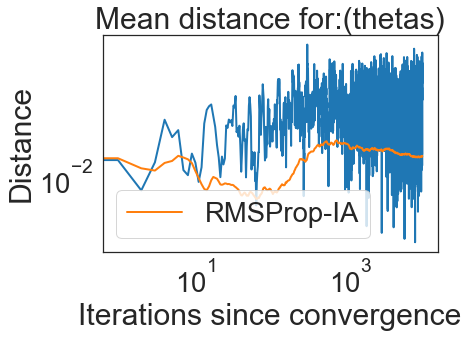

In [43]:
plt.loglog(np.mean(np.sqrt(np.square(klvi_var_param_list_rms_good_ncp[0][op_log_mf_rms_good_ncp['start_avg_mean_iters']:,2:k] - true_mean_ncp[2:])), axis=1))
plt.loglog(np.mean(np.sqrt(np.square(avg_klvi_mean_list_rms_good_ncp[0][:,2:k] - true_mean_ncp[2:])), axis=1), label='RMSProp-IA')
plt.xlabel('Iterations since convergence')
plt.ylabel('Distance')
plt.title('Mean distance for:(thetas)')
plt.legend()

####  Averaging seems to be working better here for group mean parameter with non-centered parameterisation .